# **ADApocalypse present :** "Her Side Story" - Beyond the Bechdel Test: Studying How Women Are Put Aside in Cinema 

## Project Initialisation

### Import libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import json
from collections import defaultdict
from transformers import pipeline
import ast
import plotly.express as px
import plotly.graph_objects as go

# not displaying warnings
pd.options.mode.chained_assignment = None 

# to facilitate the use of py files
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [6]:
RAW_DATA_FOLDER_PATH = 'data/raw/'
PROCESSED_DATA_FOLDER_PATH = 'data/processed/'
EXTERNAL_DATA_FOLDER_PATH = 'data/external/'
CLUSTER_JSON_PATH =  'data/raw/clusters.json'

### Filtering and transformation of several columns

# 1. Loading files


## A. CMU Movie dataset

Loading the files from the CMU movie dataset.

In [7]:
from src.data.data_loader import load_csv, load_txt

In [8]:
plot_summaries_df = load_txt(RAW_DATA_FOLDER_PATH + 'plot_summaries.txt', ['wikipedia_movie_id', 'plot_summary'])
tvtropes_df = load_csv(RAW_DATA_FOLDER_PATH + 'tvtropes.clusters.txt', has_column_names=False, is_tsv=True, column_names=['character_type', 'metadata'])
name_clusters_df = load_csv(RAW_DATA_FOLDER_PATH + 'name.clusters.txt', has_column_names=False, is_tsv=True, column_names=['Cluster_name', 'Char_actor_id'])

Loaded data from data/raw/plot_summaries.txt
Loaded data from data/raw/tvtropes.clusters.txt, shape: (500, 2)
Loaded data from data/raw/name.clusters.txt, shape: (2665, 2)


# 2. Filtering the movies

We decided to filter our raw data in order to keep the movie intersection of the 3 following files: movie.metadata, character.metadata and imdb.ratings.

We applied the following rules to filter and preprocess the files: 
- all movies without release date were dropped
- all movies with a release date outside of the range 1910-2013 were dropped
- the release date were standardized into realase year
- thanks to another external dataset the missing gender were added
- the characters without a gender were dropped 

In [9]:
from src.data.data_transformer import get_movie_ids, preprocess_char_metadata, preprocess_movie_metadata

#preprocess_movie_metadata() # to do one time in order to generate the csv file
#preprocess_char_metadata() # to do one time in order to generate the csv file

# in the preprocess_movie_metadata function, we still need to deal with the box office and the ethnicity and height of actors columns 

In [10]:
movies_metadata_df = load_csv(PROCESSED_DATA_FOLDER_PATH + 'movies_metadata.csv')
char_metadata_df = load_csv(PROCESSED_DATA_FOLDER_PATH + 'characters_metadata.csv')

Loaded data from data/processed/movies_metadata.csv, shape: (73871, 9)
Loaded data from data/processed/characters_metadata.csv, shape: (430392, 13)


In [11]:
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73871 entries, 0 to 73870
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wikipedia_movie_id        73871 non-null  int64  
 1   freebase_movie_id         73871 non-null  object 
 2   movie_name                73871 non-null  object 
 3   movie_release_date        73871 non-null  int64  
 4   movie_box_office_revenue  8326 non-null   float64
 5   movie_runtime             58230 non-null  float64
 6   movie_languages           73871 non-null  object 
 7   movie_countries           73871 non-null  object 
 8   movie_genres              73871 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 5.1+ MB


In [12]:
intersection_ids = get_movie_ids(movies_metadata_df, char_metadata_df)
movies_metadata_df = movies_metadata_df[movies_metadata_df['wikipedia_movie_id'].isin(intersection_ids['wikipedia_movie_id'])]
char_metadata_df = char_metadata_df[char_metadata_df['wikipedia_movie_id'].isin(intersection_ids['wikipedia_movie_id'])]

Now, our dataframes are preprocessed and contain the same movies.

In [13]:
print(f'We now have {intersection_ids.shape[0]} movies.')

We now have 59776 movies.


In [14]:
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59776 entries, 0 to 73870
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wikipedia_movie_id        59776 non-null  int64  
 1   freebase_movie_id         59776 non-null  object 
 2   movie_name                59776 non-null  object 
 3   movie_release_date        59776 non-null  int64  
 4   movie_box_office_revenue  8157 non-null   float64
 5   movie_runtime             49325 non-null  float64
 6   movie_languages           59776 non-null  object 
 7   movie_countries           59776 non-null  object 
 8   movie_genres              59776 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 4.6+ MB


In [15]:
char_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 429751 entries, 0 to 430391
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   wikipedia_movie_id   429751 non-null  int64  
 1   freebase_movie_id    429751 non-null  object 
 2   movie_release_date   429751 non-null  int64  
 3   char_name            188124 non-null  object 
 4   actor_date_of_birth  332247 non-null  object 
 5   actor_gender         429751 non-null  object 
 6   actor_height         149947 non-null  float64
 7   actor_ethnicity      102010 non-null  object 
 8   actor_name           429751 non-null  object 
 9   actor_age            290828 non-null  float64
 10  char_actor_id        429751 non-null  object 
 11  char_id              188132 non-null  object 
 12  actor_id             429751 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 45.9+ MB


We noticed that the columns languages and genres of the movie.metadata.csv were very broad and included a large number of different propositions, such as more than 20 different Indian dialects. In order to perform a complete analysis without getting lost in interpretation we decided to cluster them. Moreover, some countries have been wrongly labeled or are ancient territories, which we clusted for equivalent reasons.

## 2.1 Loading External datasets

Loading IMDB dataset. We plan to use it in the future to evaluate the success of a movie and link it with the genders of the actors.

The title.basics.tsv and title.ratings.tsv files are too big to be stored in the repository so all results are pre run but cannot be find again.

## Faire csv avec imdb ratings (juste read le csv)

In [16]:
from src.data.data_transformer import process_imdb_ratings
#imdb_ratings_df = process_imdb_ratings(movies_metadata_df) # to do one time in order to generate the csv file
imdb_ratings_df = load_csv(PROCESSED_DATA_FOLDER_PATH + 'imdb_ratings.csv')

Loaded data from data/processed/imdb_ratings.csv, shape: (44868, 6)


In [17]:
imdb_ratings_df.shape

(44868, 6)

In the future, we will load the Bechdel Dataset and use it to conduct gender analysis.

# 1. MOVIES

## 1.1 METADATA

### In order to perform a complete analysis, we intend to further add the columns 'director_name', 'director_gender' and 'budget' to the movies_metadata dataframe, thanks to the wikipedia_movie_id allowing us to access the library wikipedia_api

### 1.1.1 GENRES

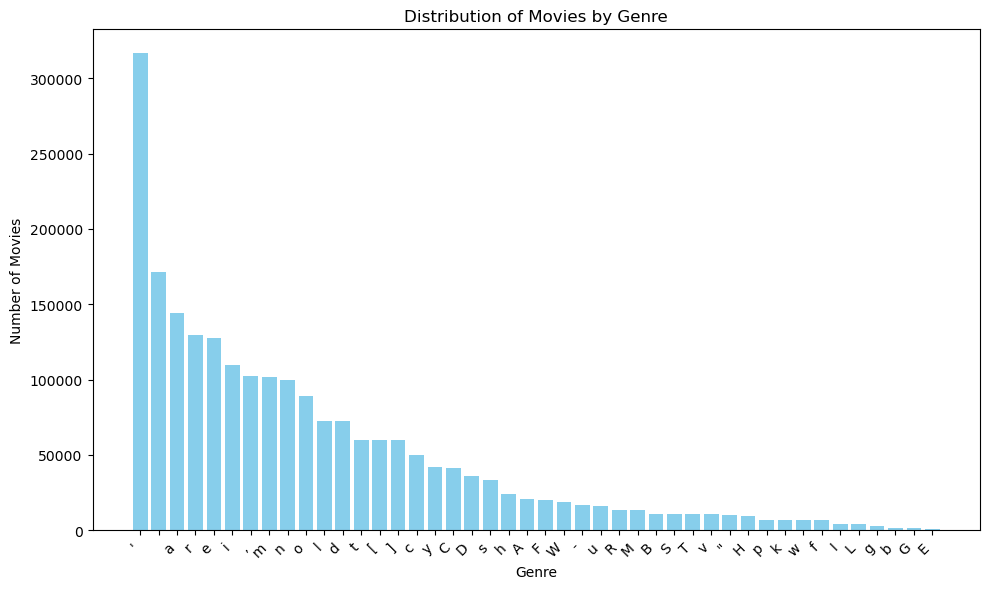

In [18]:
all_genres = movies_metadata_df['movie_genres'].copy()
all_genres = [genre for sublist in movies_metadata_df['movie_genres'] for genre in sublist]
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

genre_df = genre_df.sort_values(by='Count', ascending=False)
# keep only the genres with more than 500 movies
genre_df = genre_df[genre_df['Count'] > 500]

# Plot the distribution of genres
plt.figure(figsize=(10, 6))
plt.bar(genre_df['Genre'], genre_df['Count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The first analysis of the movie genres give us ideas and insights on how to conduct our future analysis.

From this distribution of movies by genre, we could select the top-10 genres and look at the gender distribution on them. 

Additionnally, we will also focus on some other genres because of clichés that we have spotted while doing the genre clustering:
- feminist films
- pornographic films
- LGBT films
- war and military films


### 1.1.2. LANGUAGES

We investigated this feature about the movie dataset and we have seen that it is quite similar to the country feature. Hence, we decide for further analysis to focus on the country feature since it can give us information about how a country's culture can influence the gender representation in movies.

### 1.1.3. COUNTRIES

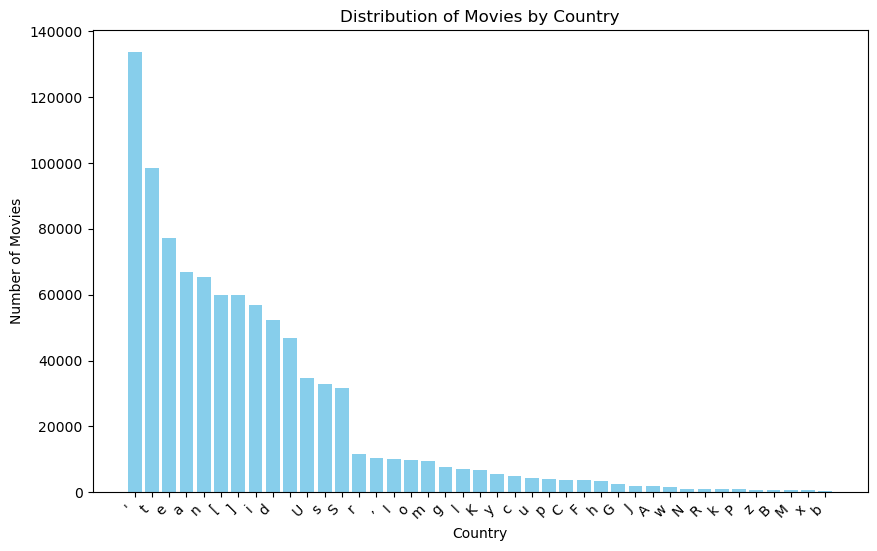

In [19]:
all_countries = movies_metadata_df['movie_countries'].copy()
all_countries = [genre for sublist in movies_metadata_df['movie_countries'] for genre in sublist]
countries_counts = Counter(all_countries)

country_df = pd.DataFrame(countries_counts.items(), columns=['Country', 'Count'])
country_df = country_df.sort_values(by='Count', ascending=False)
country_df = country_df[country_df['Count'] > 500]

plt.figure(figsize=(10, 6))
plt.bar(country_df['Country'], country_df['Count'], color='skyblue')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Country')
plt.xticks(rotation=45, ha='right') 
plt.show()

We can see that we have a lot of movies from USA, UK, and Europe. Our analysis would be occidental-centered with an exception for India and north Asia countries.

It could be really interesting to look at the difference of the gender representation depending on the part of the world. 

### 1.1.4. Box office revenue

There is a lot of missing values (more than 50%), we would like to add an external dataset. We could link it to a movie success in order to look for any correlation with the gender distribution of actors.

### 1.1.5. Runtime

In [20]:
movies_metadata_df['movie_runtime'].info()

<class 'pandas.core.series.Series'>
Index: 59776 entries, 0 to 73870
Series name: movie_runtime
Non-Null Count  Dtype  
--------------  -----  
49325 non-null  float64
dtypes: float64(1)
memory usage: 934.0 KB


There is some missing runtime values. We are still thinking about whether to use the runtime or not and hence if we should find values to remplace them.

Here are some statistics about the runtime. We can see that the minimum and maximum runtime are extreme, we could look into that more carefully in order to know why. It could also be interesting to explore if there is any correlation with the gender of the actors or characters.

In [21]:
movies_metadata_df['movie_runtime'].describe()

count    4.932500e+04
mean     1.196767e+02
std      4.859412e+03
min      1.500000e-01
25%      8.500000e+01
50%      9.500000e+01
75%      1.090000e+02
max      1.079281e+06
Name: movie_runtime, dtype: float64

### 1.1.6. Release date

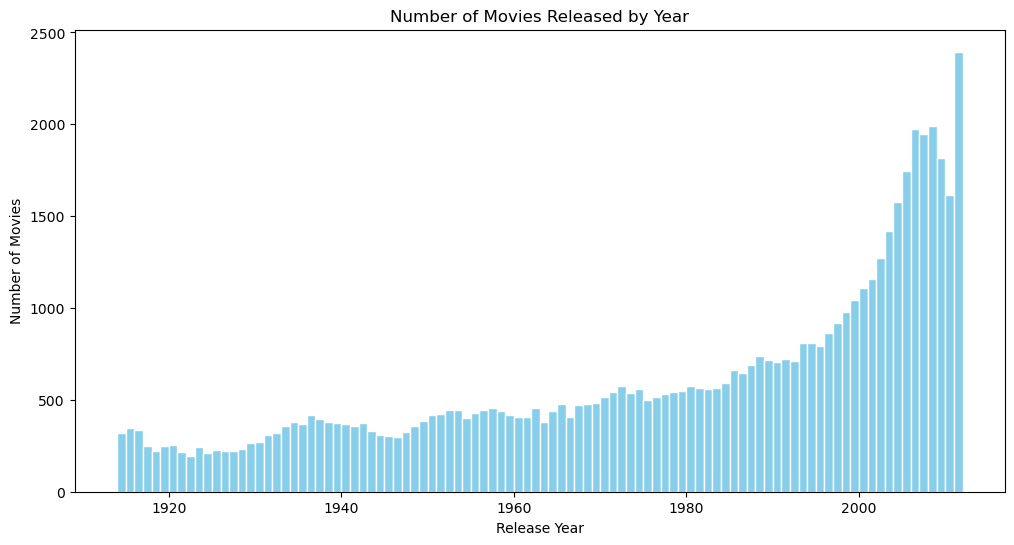

In [22]:
movies_metadata_df['movie_release_date'] = movies_metadata_df['movie_release_date'].apply(lambda x: int(x))

plt.figure(figsize=(12, 6))
plt.hist(movies_metadata_df['movie_release_date'], bins=range(movies_metadata_df['movie_release_date'].min(), movies_metadata_df['movie_release_date'].max() + 1), color='skyblue', edgecolor='white')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Released by Year')
plt.show()

We can observe that the distribution of movies produced between 1910 until 2013 follows a heavy left-skewed distribution, with a notable increase during World War I. We can now wonder whether the temporal evolution of the number of movies follows the same distribution depending on the gender of the director.

# 2. CHARACTERS

## 2.1. METADATA

We use the preprocessed dataframe.

### 2.1.1. Distributions of characters per movie

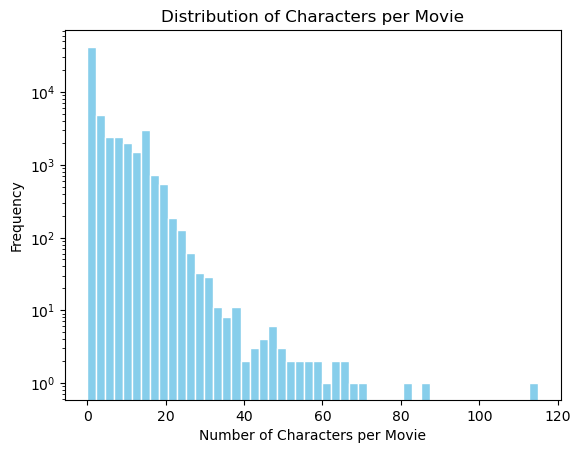

In [23]:
char_per_movie = char_metadata_df.groupby("wikipedia_movie_id")['char_name'].count().reset_index()
max_characters = char_per_movie['char_name'].max()
max_movie_id = char_per_movie[char_per_movie['char_name'] == max_characters]['wikipedia_movie_id'].values[0]

plt.hist(char_per_movie['char_name'], bins=50, log=True, color = "skyblue", edgecolor="white") 
plt.xlabel('Number of Characters per Movie')
plt.ylabel('Frequency')
plt.title('Distribution of Characters per Movie')
plt.show()

This plot shows us that the majority of movies register less than 20 characters, although the distribution is pretty constant until ~45 characters. We also notice a few outliers with more than 80 and 115 characters per movie. It would be interesting to link those results alongside with the runtime of the movie and the gender of the director.

### 2.1.2. Distribution of female and male characters

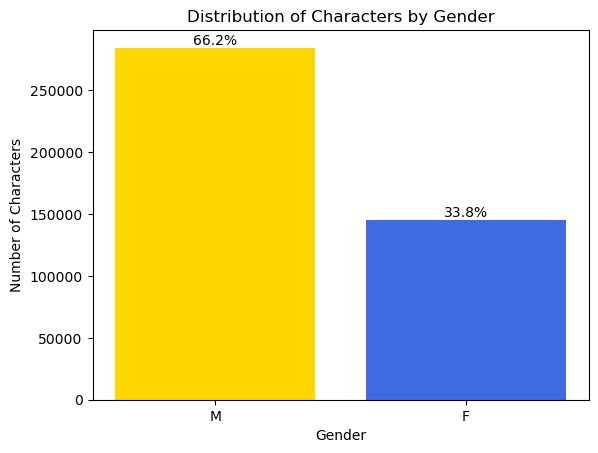

In [24]:
characters_gender = char_metadata_df[char_metadata_df["actor_gender"].isin(["F", "M"])]
gender_counts = characters_gender["actor_gender"].value_counts()

total_characters = gender_counts.sum()
percentages = (gender_counts / total_characters) * 100

plt.bar(gender_counts.index, gender_counts.values, color=['gold', 'royalblue'])
plt.xlabel('Gender')
plt.ylabel('Number of Characters')
plt.title('Distribution of Characters by Gender')

for index, (count, percentage) in enumerate(zip(gender_counts.values, percentages)):
    plt.text(index, count, f'{percentage:.1f}%', ha='center', va='bottom')


This graph illustrates genre inequalities amongst movie characters. As we can see, overall only 1/3 of the characters are female. A further analysis would be to compare the distribution of movie characters between genders based on the genre, gender of the movie director and release date of the movie.

Let's groupby on release_years_df to get also the number of movies

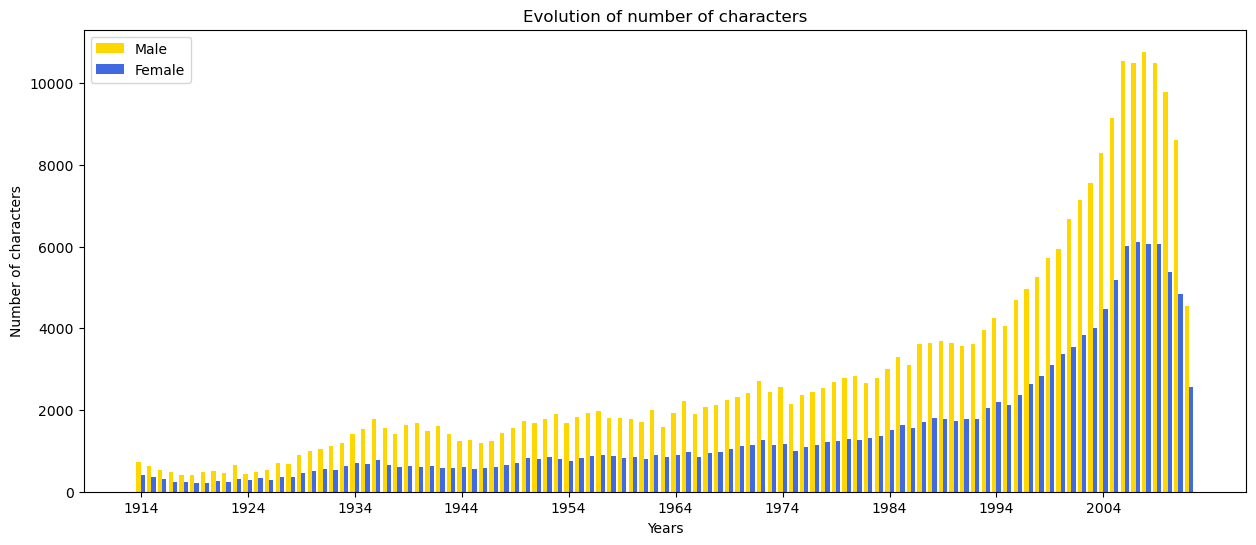

In [25]:
# convert genders into numbers
char_metadata_df["actor_gender_binary"] = char_metadata_df["actor_gender"].apply(lambda x: 0 if x=="M" else 1)
characters_gender_time = char_metadata_df.groupby("movie_release_date")["actor_gender_binary"].value_counts().unstack(fill_value=0).reset_index()

release_years_df = char_metadata_df.groupby("movie_release_date")["wikipedia_movie_id"].count()
characters_gender_time["Num_movies"] = release_years_df.values

fig, ax = plt.subplots(figsize=(15,6))
width = 0.4
x = characters_gender_time.index  # Years
x_male = x - width / 2
x_female = x + width / 2

# Plot bars side by side
ax.bar(x_male, characters_gender_time[0], width, label="Male", color="gold")
ax.bar(x_female, characters_gender_time[1], width, label="Female", color="royalblue")
ax.set_title("Evolution of number of characters")
ax.legend()
ax.set_ylabel("Number of characters")
ax.set_xlabel("Years")
ax.set_xticks(x[::10])  # Adjust to show ticks every 30 years
ax.set_xticklabels(characters_gender_time["movie_release_date"][::10]);

Overall, there are consequently more male than female characters, almost double amount. They both follow the same left-skewed distribution, which is due to the augmenting number of movies over the period studied.

### 2.1.3. Proportion of female characters

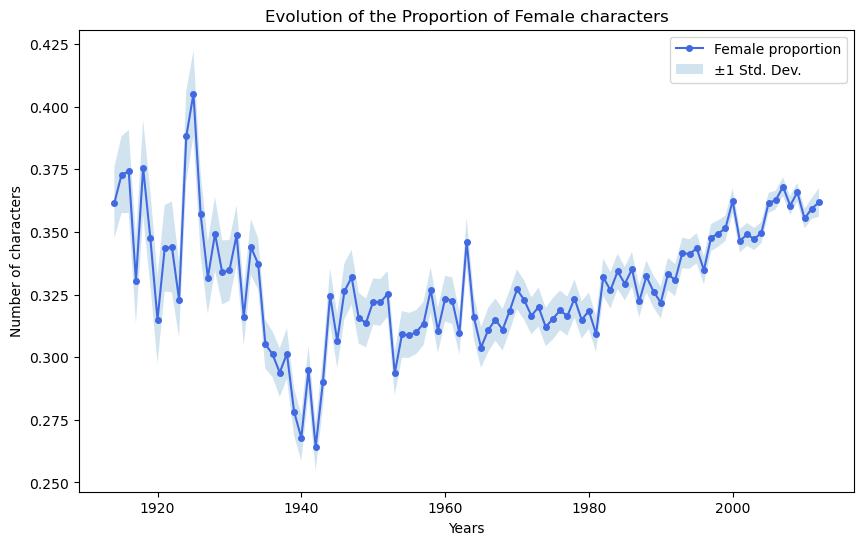

In [26]:
characters_gender_time["proportion_F"] = characters_gender_time[1]/ (characters_gender_time[1]+characters_gender_time[0])
characters_gender_time["std_F"] = np.sqrt((characters_gender_time["proportion_F"]*(1-characters_gender_time["proportion_F"])) / (characters_gender_time[1]+characters_gender_time[0]))
characters_gender_time_filtered = characters_gender_time[characters_gender_time["Num_movies"] >= 200]

y_err = characters_gender_time_filtered["std_F"]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(characters_gender_time_filtered["movie_release_date"], characters_gender_time_filtered["proportion_F"], "-o", label="Female proportion", color="royalblue", markersize=4)
ax.fill_between(characters_gender_time_filtered["movie_release_date"], characters_gender_time_filtered["proportion_F"] - y_err, characters_gender_time_filtered["proportion_F"] + y_err, alpha=0.2, label='±1 Std. Dev.')
ax.set_title("Evolution of the Proportion of Female characters")
ax.set_xlabel("Years")
ax.set_ylabel("Number of characters")
ax.legend()

Interestingly, the number of female characters over the years reached its maximum (around 40%) in 1925, which correspond to the introduction of sound in movies. The proportion then drastically dropped until 1942, with over a fourth of the characters represented by women. It then increased and stabilized at around 30-35%, where it steadily increased reaching  36% in 2013.

### 2.1.4. Distribution of the actor's ages

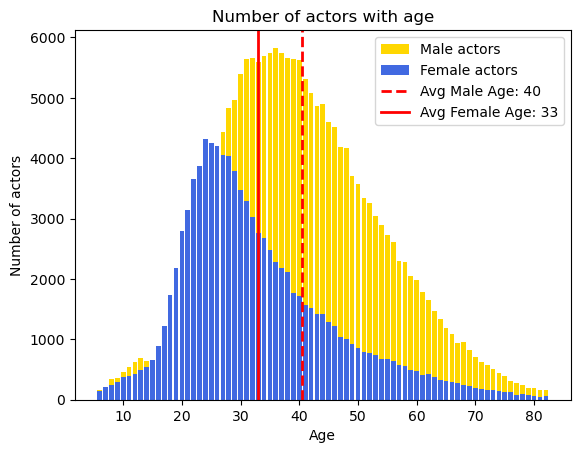

In [27]:
actors_age = char_metadata_df.copy(deep=True)
actors_age_gender = actors_age.groupby("actor_age")["actor_gender_binary"].value_counts().unstack(fill_value=0).reset_index()
actors_age_gender["Tot_actors"] = actors_age_gender[0] + actors_age_gender[1]
actors_age_gender = actors_age_gender[actors_age_gender["Tot_actors"] >= 200]

# Calculate weighted average age for each gender
avg_age_male = (actors_age_gender['actor_age'] * actors_age_gender[0]).sum() / actors_age_gender[0].sum()
avg_age_female = (actors_age_gender['actor_age'] * actors_age_gender[1]).sum() / actors_age_gender[1].sum()

fig, ax = plt.subplots()

ax.bar(actors_age_gender['actor_age'], actors_age_gender[0], label="Male actors", color="gold")
ax.bar(actors_age_gender['actor_age'], actors_age_gender[1], label="Female actors", color="royalblue")

ax.axvline(avg_age_male, color="red", linestyle="--", linewidth=2, label=f"Avg Male Age: {avg_age_male:.0f}")
ax.axvline(avg_age_female, color="red", linestyle="-", linewidth=2, label=f"Avg Female Age: {avg_age_female:.0f}")

#get handles and labels
handles, labels = ax.get_legend_handles_labels()

# #specify order of items in legend
order = [2, 3, 0, 1]

#add legend to plot
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_title("Number of actors with age")
ax.set_xlabel("Age")
ax.set_ylabel("Number of actors");

This graph illustrates the inequalities regarding opportunities given to older actors. Whereas the majority of male actors are between 30 and 50 years old, with an average of 40 years old, most women actors are only between 20 and 30 years old, with an average of 33 years old. The male actors seem to have a longer career than female ones. Once again, it would be interesting to compare this number according to the gender of the movie director and the genre of the movie. 

## 2.2. CHARACTER TYPES

In [28]:
# we keep unique values
character_types = tvtropes_df['character_type'].unique()

In [29]:
tvtropes_df.head()

,character_type,metadata
0,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
1,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
2,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
3,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."
4,adventurer_archaeologist,"{""char"": ""Indiana Jones"", ""movie"": ""Indiana Jo..."


Here, we separate the columns so it is more easy to understand.

In [30]:
tvtropes_df['metadata'] = tvtropes_df['metadata'].apply(ast.literal_eval)
tvtropes_df = pd.concat([tvtropes_df.drop(['metadata'], axis=1), tvtropes_df['metadata'].apply(pd.Series)], axis=1)
tvtropes_df = tvtropes_df.rename(columns={'char': 'char_name', 'actor': 'actor_name', 'movie': 'movie_name', 'id': 'char_actor_id'})
tvtropes_df.head()

,character_type,char_name,movie_name,char_actor_id,actor_name
0,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
1,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
2,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
3,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
4,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford


We add the character information and especially its gender.

In [31]:
tvtropes_df['actor_gender'] = tvtropes_df['actor_name'].map(char_metadata_df.set_index('actor_name')['actor_gender'].to_dict())
tvtropes_df.head()


,character_type,char_name,movie_name,char_actor_id,actor_name,actor_gender
0,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M
1,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M
2,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M
3,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M
4,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford,M


We count the number of female and male characters. There is much more males, which introduces some bias in our analysis. We are not sure if we want to use this file since it could contain biased information about genders, and the file is only 500 rows so it is quite small.

In [32]:
tvtropes_gender = tvtropes_df.groupby('actor_gender').size().reset_index(name='counts')
tvtropes_gender

,actor_gender,counts
0,F,69
1,M,431


We plot the repartition of the gender characters along the tv tropes.

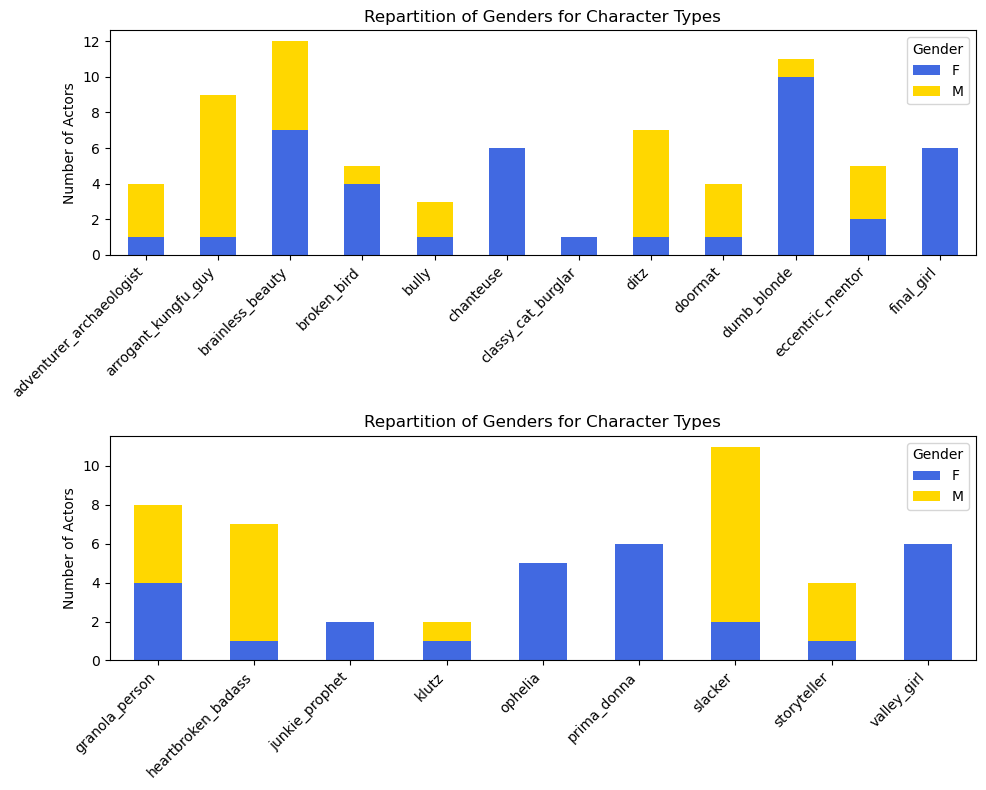

In [33]:
# Filter rows where 'actor_gender' contains 'F'
female_character_type_gender_counts = tvtropes_df.groupby(['character_type', 'actor_gender']).size().unstack(fill_value=0)
filtered_character_type_gender_counts = female_character_type_gender_counts[female_character_type_gender_counts['F'] > 0]

# Set up the number of subplots
categories_per_subplot = 12
num_subplots = (len(filtered_character_type_gender_counts) + categories_per_subplot - 1) // categories_per_subplot

fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 4 * num_subplots))

# Plot each subset in a separate subplot
for i in range(num_subplots):
    start = i * categories_per_subplot
    end = start + categories_per_subplot
    subset = filtered_character_type_gender_counts.iloc[start:end]

    subset.plot(kind='bar', stacked=True, ax=axes[i], color=['royalblue', 'gold'])
    axes[i].set_title(f"Repartition of Genders for Character Types")
    axes[i].set_xlabel("")  # Character type
    axes[i].set_ylabel("Number of Actors")
    axes[i].legend(title="Gender")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


plt.tight_layout()
plt.show()


Here, we only plotted the categories that have some female characters. As expected following societal cliches, female characters are often juged based on their appearance (ex :"dumb blond") whereas more flatterous characters are predominantly males such as "byronic_hero" or "master_swodsman". Some categories are 100% female characters: chanteuse, final_girl, ophelia, prima_donna, valley_girl. Indeed, some genders word are contained in the title of the tv tropes. As for the category brainless beauty, we observe it is almost 50-50 but considering there is really less female characters, it is obvious to see that it is disproportionate.

## 2.3. CHARACTER NAMES 

For now, we will not analyze the character names.

In [34]:
name_clusters_df

,Cluster_name,Char_actor_id
0,Stuart Little,/m/0k3wcx
1,Stuart Little,/m/0k3wbn
2,John Doe,/m/0jyg35
3,John Doe,/m/0k2_zn
4,Josh Framm,/m/0jt3p3
...,...,...
2660,John Rolfe,/m/0k5_ql
2661,John Rolfe,/m/02vd6vs
2662,Elizabeth Swann,/m/0k1xvz
2663,Elizabeth Swann,/m/0k1x_d


## 3. PLOT SUMMARIES

We focused our analysis on the content of plot summaries by using sentiment analysis on each plot, linking it to the dominent emotion.

In [ ]:
# Keep only the movies that are common to our movies dataset
df_plot_summaries_filtered = plot_summaries_df[plot_summaries_df['wikipedia_movie_id'].isin(movies_metadata_df['wikipedia_movie_id'])]
df_plot_summaries_filtered.reset_index(drop=True, inplace=True)

Investigating the length of the plots, we see that the majority of the plots are between 50 and 250 words long. 

In [ ]:
# charge pipeline for emotion detection
emotion_pipeline = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Then, we perform a sentiment analysis using Hugging Face transformers pipeline.

In [ ]:
# Function for analyzing the emotion of a text

def emotion_analysis(text):
    chunks = [text[i:i+512] for i in range(0, len(text), 512)]
    results = [emotion_pipeline(chunk) for chunk in chunks]

    # Initialize a dictionary to accumulate scores for each emotion
    emotion_scores = defaultdict(list)

    #Process each chunk and accumulate scores
    for chunk_result in results:
        for emotion in chunk_result:
            for i in range(len(emotion)):
                emotion_scores[emotion[i]['label']].append(emotion[i]['score'])
            #print(emotion_scores[emotion['label']])
            #emotion_scores[emotion['label']].append(emotion['score'])

    # Calculate the average score for each emotion
    average_scores = {emotion: sum(scores) / len(scores) for emotion, scores in emotion_scores.items()}

    return average_scores

In [ ]:
# get the emotions and dominant emotion for the first n plots
def n_first_emotions(n, df):
    df = plot_summaries_df.head(n)
    df['emotion_scores'] = df['plot_summary'].progress_apply(emotion_analysis)
    df['dominant_emotion'] = df['emotion_scores'].apply(lambda x: max(x, key=x.get))
    return df

100%|██████████| 2000/2000 [06:49<00:00,  4.89it/s]


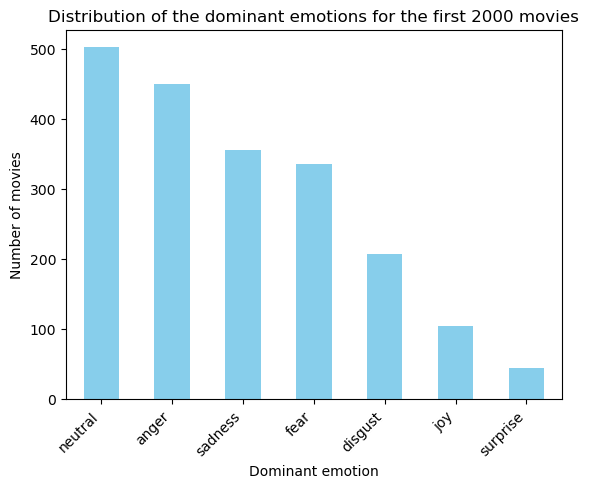

In [ ]:
# Analyzing emotions of the first 2000 plot summaries
df_plot_emotions_2000 = n_first_emotions(2000, plot_summaries_df)
df_plot_emotions_2000['dominant_emotion'].value_counts().plot(kind='bar', color='skyblue')

plt.title('Distribution of the dominant emotions for the first 2000 movies')
plt.xlabel('Dominant emotion')
plt.ylabel('Number of movies')
plt.xticks(rotation=45, ha='right')
plt.show()


We see that more film summaries are categorised as including anger, whereas few contain joy or surprise. For further analysis, we want to investigate the potential relationship between the emotions and the genders of the main actors.

# 4. Movie Directors

In [35]:
from src.data.data_transformer import get_director_name_and_gender, process_directors
# get_director_name_and_gender() # to do one time in order to generate the movies_director csv file

In [36]:
movies_director = load_csv(PROCESSED_DATA_FOLDER_PATH + 'movies_director.csv', has_column_names=False, column_names=['wikipedia_movie_id', 'director_name', 'director_gender'])[1:]
movies_director['wikipedia_movie_id'] = movies_director['wikipedia_movie_id'].astype(int)

Loaded data from data/processed/movies_director.csv, shape: (39518, 3)


In [37]:
# process_directors() # to do one time in order to generate the csv file

In [38]:
movies_directors_combined = load_csv(PROCESSED_DATA_FOLDER_PATH +'movies_directors_combined.csv')

Loaded data from data/processed/movies_directors_combined.csv, shape: (39517, 11)


In [39]:
# distribution of genders amongst movie directors
fig = px.histogram(movies_director, x='director_gender', title='Gender distribution of movies director')
fig.show()

# -------------------------------------------------------------------------

## Character distribution

In [40]:
char_directors_combined = char_metadata_df.join(movies_director.set_index('wikipedia_movie_id'), on='wikipedia_movie_id')
char_directors_combined = char_directors_combined[char_directors_combined['director_gender'].notna()]


In [41]:
char_directors_combined

,wikipedia_movie_id,freebase_movie_id,movie_release_date,char_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,char_actor_id,char_id,actor_id,actor_gender_binary,director_name,director_gender
36,261236,/m/01mrr1,1983,NaN,1950-06-20,F,NaN,NaN,Gudrun Landgrebe,32.0,/m/02vb3cv,NaN,/m/09d6hv,1,Robert van Ackeren,M
37,261236,/m/01mrr1,1983,NaN,1950-08-02,M,NaN,NaN,Mathieu Carrière,32.0,/m/02tbd9f,NaN,/m/06prxs,0,Robert van Ackeren,M
38,261236,/m/01mrr1,1983,NaN,1947-06-18,M,NaN,NaN,Hanns Zischler,35.0,/m/02vdfng,NaN,/m/09k3x_,0,Robert van Ackeren,M
39,2238856,/m/06yc6v,2005,Michael,NaN,M,NaN,NaN,Hector Elias,NaN,/m/0bf1hh6,/m/0g98dth,/m/05pxr49,0,Miranda July,F
40,2238856,/m/06yc6v,2005,Richard Swersey,1959-09-11,M,1.78,NaN,John Hawkes,NaN,/m/0k0jnm,/m/0g98dqk,/m/0785v8,0,Miranda July,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430361,30553937,/m/0g9ts5h,1998,Restaurant Manager,NaN,M,NaN,NaN,Randy Harris,NaN,/m/0jxtsx5,/m/0jxtsx8,/m/0jxtsxh,0,Sandy Tung,F
430362,30553937,/m/0g9ts5h,1998,Julia,1975-10-10,F,NaN,NaN,Natalie Ramsey,22.0,/m/0jxtsw7,/m/0jxtswb,/m/027dt0m,1,Sandy Tung,F
430363,7223293,/m/0kv0xs,1925,NaN,1894-02-28,M,NaN,NaN,Sid Smith,NaN,/m/02vcw0s,NaN,/m/02qrq5t,0,Benjamin Stoloff,M
430364,9971909,/m/02pygw1,1972,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,0,Bob Einstein,M


In [42]:
char_male_directed = char_directors_combined[char_directors_combined['director_gender'] == 'M']
char_female_directed = char_directors_combined[char_directors_combined['director_gender'] == 'F']

In [43]:
print(f"There are {char_male_directed.shape[0]} characters in movies directed by men in this dataset.")
print(f"There are {char_female_directed.shape[0]} characters in movies directed by women in this dataset.")

There are 279292 characters in movies directed by men in this dataset.
There are 29409 characters in movies directed by women in this dataset.


In [44]:
print(f"There is {char_male_directed['actor_name'].unique().shape[0]} masculine actors who play in movies directed by men in this dataset.")
print(f"There is {char_female_directed['actor_name'].unique().shape[0]} feminine actors who play in movies directed by women in this dataset.")


There is 88624 masculine actors who play in movies directed by men in this dataset.
There is 19122 feminine actors who play in movies directed by women in this dataset.


In [45]:
# Group by director_gender and count characters and unique actors
actors_chars_directors = char_directors_combined.groupby('director_gender').agg(
    total_characters=('actor_name', 'size'),
    total_actors=('actor_name', lambda x: x.nunique())
)
# Calculate percentages
actors_chars_directors['char_percentage'] = round((actors_chars_directors['total_characters'] / actors_chars_directors['total_characters'].sum()) * 100, 1)
actors_chars_directors['actor_percentage'] = round((actors_chars_directors['total_actors'] / actors_chars_directors['total_actors'].sum()) * 100, 1)

# Reset the index for better readability
summary_df = actors_chars_directors.reset_index()
summary_df

,director_gender,total_characters,total_actors,char_percentage,actor_percentage
0,F,29409,19122,9.5,17.7
1,M,279292,88624,90.5,82.3


In [46]:
# pourcentage of female and male characters in movies directed by women
grouped_female_char = char_female_directed.groupby('actor_gender').agg(
    characters=('actor_name', 'size')
)
# pourcentage of female and male characters in movies directed by men
grouped_male_char = char_male_directed.groupby('actor_gender').agg(
    characters=('actor_name', 'size')
)
# pourcentage of female and male actors in movies directed by women
grouped_female_act = char_female_directed.groupby('actor_gender').agg(
    actors=('actor_name', lambda x: x.nunique())
)
# pourcentage of female and male actors in movies directed by men
grouped_male_act = char_male_directed.groupby('actor_gender').agg(
    actors=('actor_name', lambda x: x.nunique())   
)


In [47]:
actors_by_women = round(grouped_female_act/grouped_female_act.sum()*100)
actors_by_women

,actors
actor_gender,
F,41.0
M,59.0


In [48]:
actors_by_men = round(grouped_male_act/grouped_male_act.sum()*100)
actors_by_men

,actors
actor_gender,
F,37.0
M,63.0


In [49]:
chars_by_women = round(grouped_female_char / grouped_female_char.sum() * 100)
chars_by_women

,characters
actor_gender,
F,40.0
M,60.0


In [50]:
chars_by_men = round(grouped_male_char / grouped_male_char.sum() * 100)
chars_by_men

,characters
actor_gender,
F,33.0
M,67.0


-> not a lot of differences between pourcentages of actors and characters hence we choose to focus on characters

-> interessant de se pencher sur les actrices les plus jouées avec leurs noms etc

In [51]:
import plotly.graph_objects as go

# Data
categories = ["Directed by Women", "Directed by Men"]
female_percentages = [chars_by_women.loc['F', 'characters'], chars_by_men.loc['F', 'characters']]
male_percentages = [chars_by_women.loc['M', 'characters'], chars_by_men.loc['M', 'characters']]

# Create the bar plot
fig = go.Figure()

# Female percentage bars
fig.add_trace(go.Bar(
    x=categories,
    y=female_percentages,
    name="Female",
    marker_color="lightblue"
))

# Male percentage bars
fig.add_trace(go.Bar(
    x=categories,
    y=male_percentages,
    name="Male",
    marker_color="orange"
))

# Update layout
fig.update_layout(
    title="Character Distribution by Gender Depending on Director Gender",
    xaxis_title="Directors",
    yaxis_title="Percentage (%)",
    barmode='group',
    legend_title="Actor Gender",
    template="plotly_white"
)

# Show the plot
fig.show()


FAIRE UN POINT UNIQUE SUR ACTOR NAME ET ACTOR AGE ET PUIS MOYENNE

In [52]:
char_female_directed_age = char_female_directed[((~char_female_directed['actor_age'].isnull()) & (char_female_directed['actor_age'] < 100) & (char_female_directed['actor_age'] > 0))]
char_male_directed_age = char_male_directed[((~char_male_directed['actor_age'].isnull()) & (char_male_directed['actor_age'] < 100) & (char_male_directed['actor_age'] > 0))]



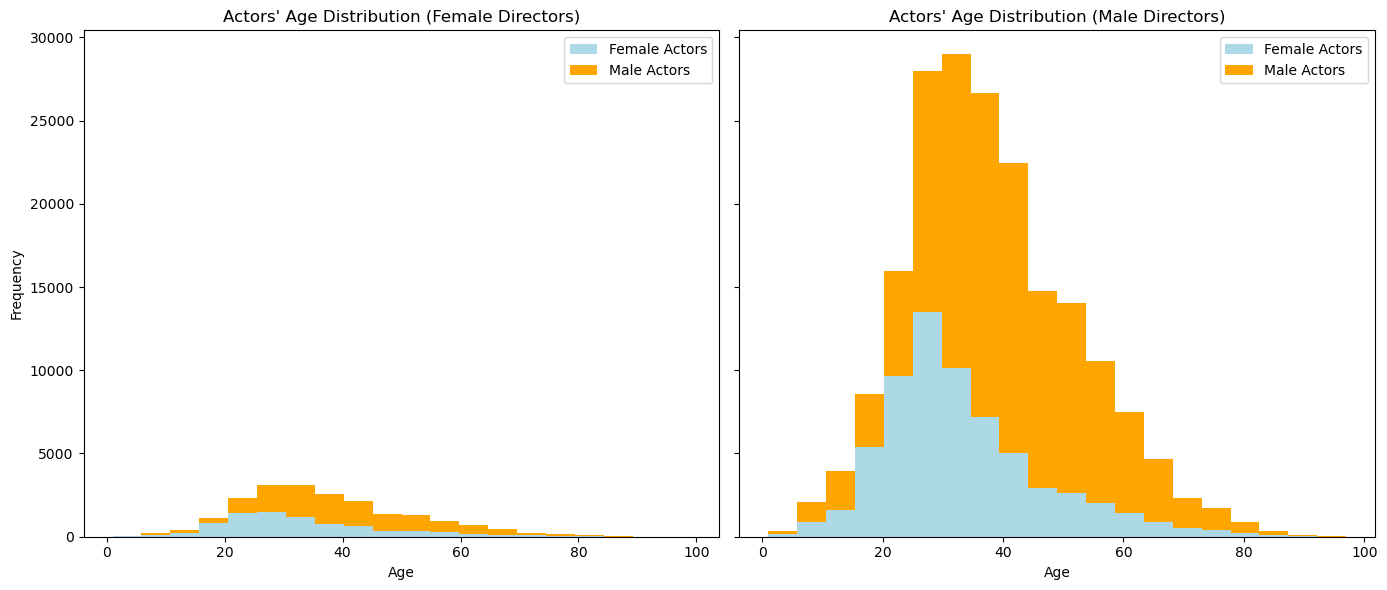

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for female directors
axes[0].hist(
    [char_female_directed_age[char_female_directed_age['actor_gender'] == 'F']['actor_age'], 
     char_female_directed_age[char_female_directed_age['actor_gender'] == 'M']['actor_age']],
    bins=20, stacked=True, label=['Female Actors', 'Male Actors'], color=['lightblue', 'orange']
)
axes[0].set_title("Actors' Age Distribution (Female Directors)")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Plot for male directors
axes[1].hist(
    [char_male_directed_age[char_male_directed_age['actor_gender'] == 'F']['actor_age'], 
     char_male_directed_age[char_male_directed_age['actor_gender'] == 'M']['actor_age']],
    bins=20, stacked=True, label=['Female Actors', 'Male Actors'], color=['lightblue', 'orange']
)
axes[1].set_title("Actors' Age Distribution (Male Directors)")
axes[1].set_xlabel("Age")
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [54]:
import plotly.graph_objects as go

# Filter and clean data
char_female_directed_age = char_female_directed[
    (~char_female_directed['actor_age'].isnull()) & 
    (char_female_directed['actor_age'] < 100) & 
    (char_female_directed['actor_age'] > 0)
]

char_male_directed_age = char_male_directed[
    (~char_male_directed['actor_age'].isnull()) & 
    (char_male_directed['actor_age'] < 100) & 
    (char_male_directed['actor_age'] > 0)
]

# Prepare normalized percentage data for female directors
female_directed_female = char_female_directed_age[char_female_directed_age['actor_gender'] == 'F']['actor_age']
female_directed_male = char_female_directed_age[char_female_directed_age['actor_gender'] == 'M']['actor_age']

female_female_percentage = female_directed_female.value_counts(normalize=True).sort_index() * 100
female_male_percentage = female_directed_male.value_counts(normalize=True).sort_index() * 100

# Prepare normalized percentage data for male directors
male_directed_female = char_male_directed_age[char_male_directed_age['actor_gender'] == 'F']['actor_age']
male_directed_male = char_male_directed_age[char_male_directed_age['actor_gender'] == 'M']['actor_age']

male_female_percentage = male_directed_female.value_counts(normalize=True).sort_index() * 100
male_male_percentage = male_directed_male.value_counts(normalize=True).sort_index() * 100

# Create percentage plots
fig = go.Figure()

# Female directors
fig.add_trace(go.Scatter(
    x=female_female_percentage.index,
    y=female_female_percentage.values,
    mode='lines',
    name="Female Actors (Female Directors)",
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=female_male_percentage.index,
    y=female_male_percentage.values,
    mode='lines',
    name="Male Actors (Female Directors)",
    line=dict(color='orange')
))

# Male directors
fig.add_trace(go.Scatter(
    x=male_female_percentage.index,
    y=male_female_percentage.values,
    mode='lines',
    name="Female Actors (Male Directors)",
    line=dict(color='lightblue', dash='dash')
))
fig.add_trace(go.Scatter(
    x=male_male_percentage.index,
    y=male_male_percentage.values,
    mode='lines',
    name="Male Actors (Male Directors)",
    line=dict(color='orange', dash='dash')
))

# Layout adjustments
fig.update_layout(
    title="Age Distribution of Actors by Director Gender (Percentage)",
    xaxis_title="Age",
    yaxis_title="Percentage (%)",
    legend_title="Actor Gender & Director Gender",
    template="plotly_white"
)

# Show the plot
fig.show()


In [55]:
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

# Define a function for KDE
def compute_kde(data, x_range, bandwidth=0.5):
    kde = gaussian_kde(data, bw_method=bandwidth)  # Apply smoothing
    return kde(x_range)

# Define age range for smoother plots
age_range = np.linspace(0, 100, 200)  # Finer range for smoother curves

# Compute KDE for each group (female actors in female-directed films, etc.)
female_directed_female_kde = compute_kde(female_directed_female, age_range)
female_directed_male_kde = compute_kde(female_directed_male, age_range)
male_directed_female_kde = compute_kde(male_directed_female, age_range)
male_directed_male_kde = compute_kde(male_directed_male, age_range)

# Normalize the KDE values so they sum to 1
female_directed_female_kde /= np.sum(female_directed_female_kde)
female_directed_male_kde /= np.sum(female_directed_male_kde)
male_directed_female_kde /= np.sum(male_directed_female_kde)
male_directed_male_kde /= np.sum(male_directed_male_kde)

# Scale the KDE to percentages (multiply by 100)
female_directed_female_percentage = female_directed_female_kde * 100
female_directed_male_percentage = female_directed_male_kde * 100
male_directed_female_percentage = male_directed_female_kde * 100
male_directed_male_percentage = male_directed_male_kde * 100

# Create smoothed percentage plots
fig = go.Figure()

# Female directors
fig.add_trace(go.Scatter(
    x=age_range,
    y=female_directed_female_percentage,
    mode='lines',
    name="Female Actors (Female Directors)",
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=age_range,
    y=female_directed_male_percentage,
    mode='lines',
    name="Male Actors (Female Directors)",
    line=dict(color='orangered')
))

# Male directors
fig.add_trace(go.Scatter(
    x=age_range,
    y=male_directed_female_percentage,
    mode='lines',
    name="Female Actors (Male Directors)",
    line=dict(color='lightblue', dash='dash')
))
fig.add_trace(go.Scatter(
    x=age_range,
    y=male_directed_male_percentage,
    mode='lines',
    name="Male Actors (Male Directors)",
    line=dict(color='orange', dash='dash')
))

# Layout adjustments
fig.update_layout(
    title="Smoothed Age Distribution of Actors by Director Gender (Percentage)",
    xaxis_title="Age",
    yaxis_title="Percentage (%)",
    legend_title="Actor Gender & Director Gender",
    template="plotly_white"
)

# Show the plot
fig.show()


## BECHDEL TEST


In [56]:
bechdel_df = load_csv(PROCESSED_DATA_FOLDER_PATH + 'bechdel_ratings.csv')

Loaded data from data/processed/bechdel_ratings.csv, shape: (3886, 4)


In [57]:
bechdel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   wikipedia_movie_id  3886 non-null   int64 
 1   movie_name          3886 non-null   object
 2   movie_release_date  3886 non-null   int64 
 3   bechdel_rating      3886 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 121.6+ KB


In [58]:
# Number from 0 to 3 (0 means no two women, 1 means no talking, 2 means talking about a man, 3 means it passes the test).
bechdel_dict = {
    '0': 'no two women',
    '1': 'no talking',
    '2': 'talking about a man',
    '3': 'passes the test'
}

In [59]:
char_female_directed_bechdel = char_female_directed[char_female_directed['wikipedia_movie_id'].isin(bechdel_df['wikipedia_movie_id'])]
char_male_directed_bechdel = char_male_directed[char_male_directed['wikipedia_movie_id'].isin(bechdel_df['wikipedia_movie_id'])]

In [60]:
print(f"There is {char_female_directed_bechdel.shape[0]} characters in movies directed by women that are in the Bechdel dataset over {char_female_directed.shape[0]} characters.")
print(f"There is {char_male_directed_bechdel.shape[0]} characters in movies directed by men that are in the Bechdel dataset over {char_male_directed.shape[0]} characters.")

There is 4426 characters in movies directed by women that are in the Bechdel dataset over 29409 characters.
There is 43210 characters in movies directed by men that are in the Bechdel dataset over 279292 characters.


In [61]:
movies_male_directed = movies_directors_combined[movies_directors_combined['director_gender'] == 'M']
movies_female_directed = movies_directors_combined[movies_directors_combined['director_gender'] == 'F']

In [62]:
print(f"There is {movies_male_directed.shape[0]} movies directed by men in the dataset.")
print(f"There is {movies_female_directed.shape[0]} movies directed by women in the dataset.")

There is 35482 movies directed by men in the dataset.
There is 4035 movies directed by women in the dataset.


In [63]:
movies_female_directed_bechdel = movies_female_directed[movies_female_directed['wikipedia_movie_id'].isin(bechdel_df['wikipedia_movie_id'])]
movies_male_directed_bechdel = movies_male_directed[movies_male_directed['wikipedia_movie_id'].isin(bechdel_df['wikipedia_movie_id'])]

In [64]:
print(f"There is {movies_female_directed_bechdel.shape[0]} characters in movies directed by women that are in the Bechdel dataset over {movies_female_directed.shape[0]} movies.")
print(f"There is {movies_male_directed_bechdel.shape[0]} characters in movies directed by men that are in the Bechdel dataset over {movies_male_directed.shape[0]} movies.")

There is 365 characters in movies directed by women that are in the Bechdel dataset over 4035 movies.
There is 3268 characters in movies directed by men that are in the Bechdel dataset over 35482 movies.


Over 3 633 movies (39 517 in total) in the bechdel dataset, around 63% of them passes the test (3/3), maybe we could assume (but loss of generality maybe?) that the other not in the bechdel dataset don't pass the test?

In [65]:
movies_female_directed_bechdel = pd.merge(movies_female_directed_bechdel, bechdel_df[['wikipedia_movie_id', 'bechdel_rating']], on='wikipedia_movie_id', how='left')
movies_male_directed_bechdel = pd.merge(movies_male_directed_bechdel, bechdel_df[['wikipedia_movie_id', 'bechdel_rating']], on='wikipedia_movie_id', how='left')

In [66]:
female_bechdel_df = movies_female_directed_bechdel.groupby('bechdel_rating').agg(
    pourcentage=('bechdel_rating', 'size')
)
female_bechdel_df = round(female_bechdel_df/female_bechdel_df.sum()*100)
male_bechdel_df = movies_male_directed_bechdel.groupby('bechdel_rating').agg(
    pourcentage=('bechdel_rating', 'size')
)
male_bechdel_df = round(male_bechdel_df/male_bechdel_df.sum()*100)
combined_df = pd.merge(female_bechdel_df, male_bechdel_df, on='bechdel_rating', how='outer')


In [67]:
import plotly.graph_objects as go

# Data
categories = ["0: no two women", "1: no talking", "2: talking about a man", "3: passes the test"]
female_percentages = combined_df['pourcentage_x'].values
male_percentages = combined_df['pourcentage_y'].values

# Set up the bar plot
fig = go.Figure()

# Female percentage bars
fig.add_trace(go.Bar(
    x=categories,
    y=female_percentages,
    name="Female",
    marker_color="blue"
))

# Male percentage bars
fig.add_trace(go.Bar(
    x=categories,
    y=male_percentages,
    name="Male",
    marker_color="orangered"
))

# Update layout
fig.update_layout(
    title="Bechdel Ratings on Movies by Director Gender",
    xaxis_title="Bechdel Ratings",
    yaxis_title="Percentage (%)",
    barmode='group',
    legend_title="Director Gender",
    template="plotly_white"
)

# Show the plot
fig.show()


could be interesting to print which movies are the ones with a score of 0

## Tv tropes types

In [68]:
tvtropes_df['wikipedia_movie_id'] = tvtropes_df['movie_name'].map(movies_metadata_df.set_index('movie_name')['wikipedia_movie_id'].to_dict())
tvtropes_directors = tvtropes_df[tvtropes_df['wikipedia_movie_id'].isin(movies_directors_combined['wikipedia_movie_id'])]
tvtropes_directors = tvtropes_directors.join(movies_director.set_index('wikipedia_movie_id'), on='wikipedia_movie_id')
tvtropes_female_directors = tvtropes_directors[tvtropes_directors['director_gender'] == 'F']
tvtropes_male_directors = tvtropes_directors[tvtropes_directors['director_gender'] == 'M']


In [69]:
print(f"There is {tvtropes_female_directors['character_type'].unique().shape[0]} character types in movies directed by women in this dataset.")
print(f"There is {tvtropes_male_directors['character_type'].unique().shape[0]} character types in movies directed by men in this dataset.")
print(f"There is {tvtropes_df['character_type'].unique().shape[0]} character types in this dataset.")

There is 16 character types in movies directed by women in this dataset.
There is 71 character types in movies directed by men in this dataset.
There is 72 character types in this dataset.


In [70]:
not_in_male_directors = ~np.isin(tvtropes_df['character_type'].unique(), tvtropes_male_directors['character_type'].unique())
print(f"The only type not represented in movies directed by men is the {tvtropes_df['character_type'].unique()[not_in_male_directors][0]}.")


The only type not represented in movies directed by men is the child_prodigy.


In [71]:
tvtropes_female_directors['character_type'].value_counts()

character_type
valley_girl                4
crazy_jealous_guy          3
dumb_blonde                3
brainless_beauty           2
jerk_jock                  2
big_man_on_campus          1
byronic_hero               1
child_prodigy              1
ditz                       1
egomaniac_hunter           1
father_to_his_men          1
morally_bankrupt_banker    1
prima_donna                1
romantic_runnerup          1
stoner                     1
surfer_dude                1
Name: count, dtype: int64

In [72]:
tvtropes_male_directors['character_type'].value_counts()

character_type
crazy_jealous_guy              21
corrupt_corporate_executive    19
psycho_for_hire                14
father_to_his_men              13
byronic_hero                   13
                               ..
morally_bankrupt_banker         2
trickster                       2
valley_girl                     2
junkie_prophet                  2
classy_cat_burglar              1
Name: count, Length: 71, dtype: int64

In [73]:
female_character_type_gender_counts = tvtropes_female_directors.groupby(['character_type', 'actor_gender']).size().unstack(fill_value=0)
categories = female_character_type_gender_counts.index
female_counts = female_character_type_gender_counts.iloc[:, 0]  # Assuming the first column is for females
male_counts = female_character_type_gender_counts.iloc[:, 1]    # Assuming the second column is for males

# Create the figure
fig = go.Figure()

# Add female counts
fig.add_trace(go.Bar(
    x=categories,
    y=female_counts,
    name='Female',
    marker_color='royalblue'
))

# Add male counts
fig.add_trace(go.Bar(
    x=categories,
    y=male_counts,
    name='Male',
    marker_color='orangered'
))

# Update layout
fig.update_layout(
    barmode='stack',
    title="Gender distribution for character types in movies directed by Women",
    xaxis_title="Character Types",
    yaxis_title="Number of Actors",
    legend_title="Gender",
    template="plotly_white"
)

# Show the plot
fig.show()

In [74]:
male_character_type_gender_counts = tvtropes_male_directors.groupby(['character_type', 'actor_gender']).size().unstack(fill_value=0)
categories = male_character_type_gender_counts.index
female_counts = male_character_type_gender_counts.iloc[:, 0]  # Assuming the first column is for females
male_counts = male_character_type_gender_counts.iloc[:, 1]    # Assuming the second column is for males

# Create the figure
fig = go.Figure()

# Add female counts
fig.add_trace(go.Bar(
    x=categories,
    y=female_counts,
    name='Female',
    marker_color='royalblue'
))

# Add male counts
fig.add_trace(go.Bar(
    x=categories,
    y=male_counts,
    name='Male',
    marker_color='orangered'
))

# Update layout
fig.update_layout(
    barmode='stack',
    title="Gender distribution for character types in movies directed by Men",
    xaxis_title="Character Types",
    yaxis_title="Number of Actors",
    legend_title="Gender",
    template="plotly_white"
)

# Show the plot
fig.show()

In [122]:
film_tropes_df = load_csv(EXTERNAL_DATA_FOLDER_PATH + 'film_tropes.csv')


Loaded data from data/external/film_tropes.csv, shape: (751594, 6)


In [123]:
tropes_list = film_tropes_df['Trope'].unique().tolist()


In [124]:
character_types_list = character_types.tolist()

In [125]:
character_types_list = [''.join(word.capitalize() for word in trope.split('_')) for trope in character_types_list]


In [126]:
filtered_film_tropes_df = film_tropes_df[film_tropes_df['Trope'].isin(character_types_list)]

In [119]:
def transform_title(title):
    # Remove non-alphanumeric characters except spaces
    title = ''.join(char if char.isalnum() or char.isspace() else '' for char in title)
    # Convert to PascalCase
    return ''.join(word.capitalize() for word in title.split())


In [120]:
movie_names_list = [transform_title(name) for name in movies_metadata_df['movie_name'].unique().tolist()]

In [128]:
filtered_film_tropes_df = filtered_film_tropes_df[filtered_film_tropes_df['Title'].isin(movie_names_list)]

In [135]:
filtered_film_tropes_df

,Title,Trope,trope_id
111,ABeautifulMind,AbsentMindedProfessor,t00046
645,ABugsLife,PsychoForHire,t17885
667,ABugsLife,TranquilFury,t24279
1590,ACinderellaStory,DumbBlonde,t06371
1929,AClockworkOrange,DirtyCop,t05744
...,...,...,...
750502,Zoolander,DumbBlonde,t06371
750519,Zoolander,CorruptCorporateExecutive,t04515
750562,Zoolander,BrainlessBeauty,t02750
751508,Zulu,LoveableRogue,t26959


In [134]:
filtered_film_tropes_df = filtered_film_tropes_df.drop('title_id', axis=1)

In [136]:
movies_directors_combined_temp = movies_directors_combined.copy()
movies_directors_combined_temp['movie_name'] = movies_directors_combined_temp['movie_name'].apply(transform_title)

In [137]:
movies_directors_combined_temp

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,director_name,director_gender
0,9363483,/m/0285_cd,WhiteOfTheEye,1987,NaN,110.0,['English'],['United Kingdom'],['Thriller'],Donald Cammell,M
1,261236,/m/01mrr1,AWomanInFlames,1983,NaN,106.0,['German'],['Germany'],['Drama'],Robert van Ackeren,M
2,10408933,/m/02qc0j7,AlexandersRagtimeBand,1938,3600000.0,106.0,['English'],['United States'],"['Music and Dance', 'Comedy', 'Black-and-white']",Henry King,M
3,175026,/m/017n1p,SarahAndSon,1930,NaN,86.0,['English'],['United States'],"['Drama', 'Black-and-white']",Dorothy Arzner,F
4,6631279,/m/0gffwj,LittleCity,1997,NaN,93.0,['English'],['United States'],"['Comedy', 'Independent', 'Drama', 'Romance']",Roberto Benabib,M
...,...,...,...,...,...,...,...,...,...,...,...
39512,24209227,/m/07k5mlk,TheTimeThePlaceAndTheGirl,1946,NaN,105.0,['English'],['United States'],"['Comedy', 'Romance', 'Music and Dance']",David Butler,M
39513,3868432,/m/0b44p5,IntoTheMirror,2003,NaN,113.0,['Korean'],['South Korea'],['Horror'],Kim Sung-ho,F
39514,15394941,/m/03m6zh4,GopiKishan,1994,NaN,NaN,['Indian'],['India'],"['Drama', 'Action', 'Crime and Mystery', 'Come...",Mukesh Duggal [ a ],M
39515,23851782,/m/06_vb43,TheGhostTrain,1941,NaN,82.0,['English'],['United Kingdom'],"['Crime and Mystery', 'Thriller', 'Comedy', 'H...",Walter Forde,M


In [138]:
# add the director gender to the filtered_film_tropes_df with the movies_director dataframe 
filtered_film_tropes_df = filtered_film_tropes_df.join(movies_directors_combined_temp.set_index('movie_name'), on='Title')

In [140]:
filtered_film_tropes_df = filtered_film_tropes_df.drop(['freebase_movie_id', 'movie_release_date','movie_box_office_revenue', 'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres'], axis=1)

In [ ]:
filtered_film_tropes_df.head(3)

,Title,Trope,trope_id,wikipedia_movie_id,director_name,director_gender
111,ABeautifulMind,AbsentMindedProfessor,t00046,3569822.0,Ron Howard,M
645,ABugsLife,PsychoForHire,t17885,460442.0,John Lasseter,M
667,ABugsLife,TranquilFury,t24279,460442.0,John Lasseter,M


In [143]:
# keep only the non na values
filtered_film_tropes_df = filtered_film_tropes_df.dropna()

In [171]:
filtered_film_tropes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3179 entries, 111 to 750562
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               3179 non-null   object 
 1   Trope               3179 non-null   object 
 2   trope_id            3179 non-null   object 
 3   wikipedia_movie_id  3179 non-null   float64
 4   director_name       3179 non-null   object 
 5   director_gender     3179 non-null   object 
dtypes: float64(1), object(5)
memory usage: 173.9+ KB


In [151]:
tvtropes_df.head()
tvtropes_directors.head()

,character_type,char_name,movie_name,char_actor_id,actor_name,actor_gender,wikipedia_movie_id,director_name,director_gender
0,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M,1486573,Donald Petrie,M
2,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M,605676,Gordon Douglas,M
3,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M,28327,Roland Emmerich,M
4,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford,M,1252914,Steven Spielberg,M
6,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Temple of Doom,/m/0jzx9b,Harrison Ford,M,81503,Steven Spielberg,M


In [166]:
male_film_tropes_df = filtered_film_tropes_df[filtered_film_tropes_df['director_gender'] == 'M']
female_film_tropes_df = filtered_film_tropes_df[filtered_film_tropes_df['director_gender'] == 'F']


In [167]:
male_film_tropes_df.groupby('Trope').size().sort_values(ascending=False).head(10)


Trope
FinalGirl                    248
DirtyCop                     239
CorruptCorporateExecutive    235
JerkJock                     141
CrazyJealousGuy              133
PsychoForHire                127
HenpeckedHusband             116
TranquilFury                 110
BrokenBird                   105
DumbBlonde                    95
dtype: int64

In [170]:
female_tv_tropes = tvtropes_directors[tvtropes_directors['director_gender'] == 'F']
female_tv_tropes.groupby('character_type').size().sort_values(ascending=False).head(10)

character_type
valley_girl          4
crazy_jealous_guy    3
dumb_blonde          3
brainless_beauty     2
jerk_jock            2
big_man_on_campus    1
byronic_hero         1
child_prodigy        1
ditz                 1
egomaniac_hunter     1
dtype: int64

In [168]:
female_film_tropes_df.groupby('Trope').size().sort_values(ascending=False).head(10)

Trope
FinalGirl                    20
DumbBlonde                   13
BrainlessBeauty              11
JerkJock                     10
BrokenBird                    9
ChildProdigy                  9
CrazyJealousGuy               9
CorruptCorporateExecutive     8
ValleyGirl                    8
HenpeckedHusband              7
dtype: int64

In [150]:
filtered_film_tropes_df.groupby('director_gender').size()

director_gender
F     191
M    2988
dtype: int64

In [149]:
filtered_film_tropes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3179 entries, 111 to 750562
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               3179 non-null   object 
 1   Trope               3179 non-null   object 
 2   trope_id            3179 non-null   object 
 3   wikipedia_movie_id  3179 non-null   float64
 4   director_name       3179 non-null   object 
 5   director_gender     3179 non-null   object 
dtypes: float64(1), object(5)
memory usage: 173.9+ KB


In [153]:
genderedness_df = load_csv(EXTERNAL_DATA_FOLDER_PATH+ 'genderedness_filtered.csv')

Loaded data from data/external/genderedness_filtered.csv, shape: (20931, 9)


In [154]:
genderedness_df.head()

,Trope,Gender Ratio,Tokens,FemaleTokens,MaleTokens,Corpus,Normalized Gender Ratio,TotalMFTokens,TokenRatio
0,SeaMine,0.0,1270,0.0,14.0,ah naval mines just the thing to catch unwary ...,-1.0,14.0,0.011024
1,ArbitraryHeadcountLimit,0.0,1754,0.0,37.0,trope common in realtime strategy games in whi...,-1.0,37.0,0.021095
2,EasyModeMockery,0.0,1064,0.0,12.0,\neasy mode mockery is where the game radicall...,-1.0,12.0,0.011278
3,ViolenceIsNotAnOption,0.0,1405,0.0,29.0,there are a lot of problems a person can solve...,-1.0,29.0,0.020641
4,SuperweaponAverageJoe,0.0,1204,0.0,28.0,some characters arent really cut out to be dan...,-1.0,28.0,0.023256


In [162]:
tvtropes_stats_df = genderedness_df[genderedness_df['Trope'].isin(filtered_film_tropes_df['Trope'].unique())]

In [169]:
tvtropes_stats_df[tvtropes_stats_df['Trope'] == 'FinalGirl']

,Trope,Gender Ratio,Tokens,FemaleTokens,MaleTokens,Corpus,Normalized Gender Ratio,TotalMFTokens,TokenRatio
20438,FinalGirl,2.539276,30829,1508.0,491.0,\nthe simplest definition of this is the last ...,0.542282,1999.0,0.064842


In [ ]:
tvtropes_stats_df = tvtropes_stats_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)


In [172]:
filtered_stats_df = tvtropes_stats_df[tvtropes_stats_df['Gender Ratio'] > 1.0]

In [174]:
filtered_stats_df.info()    

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 11643 to 20819
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Trope                    11 non-null     object 
 1   Gender Ratio             11 non-null     float64
 2   Tokens                   11 non-null     int64  
 3   FemaleTokens             11 non-null     float64
 4   MaleTokens               11 non-null     float64
 5   Corpus                   11 non-null     object 
 6   Normalized Gender Ratio  11 non-null     float64
 7   TotalMFTokens            11 non-null     float64
 8   TokenRatio               11 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 880.0+ bytes


In [175]:
filtered_stats_df

,Trope,Gender Ratio,Tokens,FemaleTokens,MaleTokens,Corpus,Normalized Gender Ratio,TotalMFTokens,TokenRatio
11643,PlayfulHacker,1.018448,3312,59.0,136.0,\nas opposed to the malicious cracker who uses...,-0.381424,195.0,0.058877
12398,CrazyJealousGuy,1.066865,11832,432.0,931.0,\nmeet the spear counterpart to the clingy jea...,-0.352018,1363.0,0.115196
14858,AdventurerArchaeologist,1.252486,7993,112.0,189.0,\n\nin real life archeology or modern archeolo...,-0.239276,301.0,0.037658
15045,HenpeckedHusband,1.268249,13286,610.0,1009.0,\nthe poor guy he squirms under the thumb of a...,-0.229703,1619.0,0.121858
15558,RomanticRunnerup,1.315271,4631,152.0,237.0,you know there isnt really anything wrong with...,-0.201142,389.0,0.083999
20166,BrainlessBeauty,2.289280,9929,506.0,238.0,\na specific version of the ditz an attractive...,0.390442,744.0,0.074932
20380,DumbBlonde,2.485562,12771,542.0,192.0,\nthe stereotypical assumption is that blondes...,0.509658,734.0,0.057474
20438,FinalGirl,2.539276,30829,1508.0,491.0,\nthe simplest definition of this is the last ...,0.542282,1999.0,0.064842
20452,BrokenBird,2.553351,10739,842.0,268.0,\nthese characters often female are coping wit...,0.550831,1110.0,0.103362
20690,ClassyCatBurglar,2.791364,2193,102.0,21.0,\nwalking talking purring class she doesnt ste...,0.695393,123.0,0.056088


In [182]:
filtered_film_tropes_df[filtered_film_tropes_df['Trope'] == 'DumbBlonde'].groupby('director_gender').size()

director_gender
F    13
M    95
dtype: int64

In [178]:
filtered_film_tropes_df.groupby('director_gender').size()

director_gender
F     191
M    2988
dtype: int64